# Data and AI Democratization through PromptToQueryResult Function

In the context of data and AI democratization, `PromptToQueryResult` could be a function that translates natural language prompts into database queries. This could be part of a larger system that allows non-technical users to interact with databases using natural language, which would democratize access to data and AI.

## Business Value and Domain Problem Solutions

### Business Value:

- **Increased Efficiency:** Non-technical users can retrieve data without needing to learn SQL or other query languages, or without needing to wait for technical staff to retrieve the data for them.
- **Reduced Costs:** Less time and resources are spent on training staff to use complex database systems, and less time is spent on data retrieval tasks by technical staff.
- **Improved Decision Making:** With easier access to data, decision-making can be data-driven and timely, leading to better business outcomes.

### Domain Problem Solved:

- **Data Accessibility:** One of the challenges in data democratization is making data accessible to non-technical users. `PromptToQueryResult` could help solve this problem by providing a natural language interface to databases.
- **AI Democratization:** By using AI to translate natural language prompts into database queries, `PromptToQueryResult` could also contribute to AI democratization. It could be part of a system that allows users to leverage the power of AI without needing to understand the technical details.

## Implementation Details

The selected code is written in Python and it's part of a larger program that uses a plugin-based architecture. The code is using a kernel object to manage plugins and their functions.

- **Variable Definitions:** First, two variables are defined: `plugins_directory` and `file_path`. The `plugins_directory` variable is set to the string `"plugins"`, which is presumably the directory where the plugins are stored. The `file_path` variable is set to `"data_schema.txt"`, which is likely a file that contains a data schema.

- **Reading Data Schema:** The `read_data_schema_from_file` function is then called with `file_path` as an argument. This function reads the data schema from the specified file and returns it as a string. The returned data schema is stored in the `data_schema` variable.

- **Conditional Plugin Import:** Next, there's an if-statement that checks the `prompt_rephrase` variable. If `prompt_rephrase` is true, the code imports a plugin named `"PromptPlugin"` from the plugins directory using the `import_plugin_from_prompt_directory` method of the kernel object. This method returns a dictionary-like object of functions provided by the plugin. The `"PromptRephraser"` function from the `"PromptPlugin"` plugin is then stored in the `rephraserFunction` variable.

- **Function Invocation:** The `rephraserFunction` is then invoked asynchronously using the `invoke` method of the kernel object. The `invoke` method is called with two arguments: the function to be invoked and a `KernelArguments` object that contains the data schema and a query. The result of the function invocation is stored in the `rephrased_prompt` variable.

- **Importing Another Plugin:** Finally, the code imports another plugin named `"DataPlugin"` from the plugins directory and stores the `"DatabaseDescriptor"` function from this plugin in the `descriptorFunction` variable. This function can presumably be used later in the code to describe a database based on the data schema.


In [52]:
import semantic_kernel as sk
from services import Service
import re
import sqlite3
import pandas as pd
import os
from dotenv import dotenv_values
import semantic_kernel.connectors.ai.hugging_face as sk_hf
import datetime
import json

async def GenerateQuestions(selectedService=Service.AzureOpenAI):
    """
    Generates possible questions using the Semantic Kernel and prints the results.
    """
    kernel = sk.Kernel()
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    elif selectedService == Service.HuggingFace:
        from semantic_kernel.connectors.ai.hugging_face import HuggingFaceTextCompletion
        modelname, api_key = hugging_face_settings_from_dot_env()
        print(modelname, api_key)
        service_id = "huggingface_text_completion"
        kernel.add_service(HuggingFaceTextCompletion(service_id=modelname, ai_model_id=modelname, model_kwargs={"token": api_key}))
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    queryGeneratorFunction = promptFunctions["QuestionGenerator"]
    result = await kernel.invoke(queryGeneratorFunction, sk.KernelArguments(data_schema=data_schema))
    result_string = result.data if hasattr(result, 'data') else str(result)
    # Generate a unique filename based on the current date
    filename = "questions/" + datetime.datetime.now().strftime("%Y-%m-%d") + ".txt"

    # Write result_string to the file
    with open(filename, 'w') as file:
        file.write(result_string)

    # Print the filename
    print("Result saved to:", filename)
    print(result_string)

async def ReadQuestionsAndGenerateAnswers(filename, debug=False, selectedService=Service.AzureOpenAI):
    """
    Reads questions from a file and generates answers using the Semantic Kernel.

    Args:
        filename (str): The name of the file containing the questions.

    """
    with open(filename, 'r') as file:
        content = file.read()

    # Extract the filename from the full path
    filename = os.path.basename(filename)

    # Remove the file extension
    filename = os.path.splitext(filename)[0]

    # Create the directory path
    directory_path = "answers/" + filename 

    print("Directory path: ", directory_path)   

    # Create the directory if it does not exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    

    data = json.loads(content)
    i = 0
    for item in data:
        complexity = item["complexity"]
        queries = item["queries"]
        
        for question in queries:
            print("Index:" , i)
            print("Question: ", question)
            print("Complexity: ", complexity)
            questionFolderName = i.__str__() + "_" + complexity
            if not os.path.exists(directory_path + "/"  + questionFolderName + "/"):
                os.makedirs(directory_path + "/"  + questionFolderName + "/")

            try:
                await PromptToQueryResult(debug=debug, prompt_rephrase=False, selectedService=selectedService, query=question, outputFileDir=directory_path + "/" + questionFolderName + "/")
            except Exception as e:
                error_message = str(e)
                with open(directory_path + "/" + questionFolderName + "/error.txt", "w") as file:
                    file.write(error_message)
            i = i + 1

def make_safe_folder_name(folder_name):
    # Define a regular expression pattern to match invalid characters
    # This example replaces anything that is not a letter, number, underscore, or hyphen with an underscore
    safe_folder_name = re.sub(r'[^A-Za-z0-9_\-]', '_', folder_name)
    return safe_folder_name

async def PromptToQueryResult(debug=False, prompt_rephrase=False, selectedService=Service.AzureOpenAI, query=None, outputFileDir=""):
    """
    Prompts the user for a query, rephrases the prompt if required, and executes the query using the Semantic Kernel.

    Args:
        debug (bool, optional): If True, prints debug information. Defaults to False.
        prompt_rephrase (bool, optional): If True, rephrases the prompt using a rephraser plugin. Defaults to False.

    Returns:
        DataFrame or any: The result of the executed query, or 'any' if no query is executed.
    """
    kernel = sk.Kernel()
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    elif selectedService == Service.HuggingFace:
        from semantic_kernel.connectors.ai.hugging_face import HuggingFaceTextCompletion

        modelname, api_key = hugging_face_settings_from_dot_env()
        print(modelname, api_key)
        service_id = "huggingface_text_completion"
        kernel.add_service(HuggingFaceTextCompletion(service_id=modelname, ai_model_id=modelname, model_kwargs={"token": api_key}))
    
    if(query is None):
        query = input("Enter your query: ")  # Get query from user
    rephrased_prompt = query
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    if(prompt_rephrase):
        promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "PromptPlugin")
        rephraserFunction = promptFunctions["PromptRephraser"]
        rephrased_prompt_result = await kernel.invoke(rephraserFunction, sk.KernelArguments(data_schema=data_schema, query=query))
        rephrased_prompt = rephrased_prompt_result.data if hasattr(rephrased_prompt_result, 'data') else str(rephrased_prompt_result)

    dataFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    descriptorFunction = dataFunctions["DatabaseDescriptor"]

    savePlotToDisk = ""
    if(outputFileDir != ""):
        savePlotToDisk = "Generated plots should be saved in the directory: " + outputFileDir + "plot.png"

    if(outputFileDir != ""):
        # Write rephrased prompt to query.txt file
        with open(outputFileDir + "user_prompt.txt", "w") as file:
            file.write(rephrased_prompt)

    result = await kernel.invoke(descriptorFunction, sk.KernelArguments(data_schema=data_schema, query= rephrased_prompt, save_plot_to_disk = savePlotToDisk))
    result_string = result.data if hasattr(result, 'data') else str(result)
    if(debug):
        print(result_string)
    matches_sql = parse_text_between_tags(result_string,"<sql>", "</sql>")

    if(prompt_rephrase):
        print("User query: " + query)
    print("Rephrased prompt: " + rephrased_prompt)
    if len(matches_sql) > 0:
        sql = matches_sql[0]
        if(outputFileDir != ""):
            # Write query to .txt file
            with open(outputFileDir + "sql_query.txt", "w") as file:
                file.write(sql)
        if debug:
            print(sql)
        df = run_sql_query(sql)
    
    

    matches_python = parse_text_between_tags(result_string,"<python>", "</python>")
    if len(matches_python) > 0:
        if debug:
            print(matches_python[0])
        try:
            db_conn = os.getenv("DB_CONNECTION_STRING")
            conn = sqlite3.connect(db_conn)
            exec(matches_python[0])
            conn.close()

            if(outputFileDir != ""):
                # Write python code to .txt file
                with open(outputFileDir + "python_code.txt", "w") as file:
                    file.write(matches_python[0])

        except Exception as e:
            if debug:
                print('hata:' + e)
        except:
            print("An exception occurred")
    if len(matches_sql) > 0:
        df.head()
        if(outputFileDir != ""):
            df.to_csv(outputFileDir + "output.csv", index=False)
        return df
    else:  
        return any

def hugging_face_settings_from_dot_env() :

    config = dotenv_values(".env")
    model_name = config.get("HUGGINGFACE_MODEL_NAME", None)
    api_key = config.get("HUGGINGFACE_API_KEY", None)

    return model_name, api_key

def read_data_schema_from_file(file_path):
    """
    Reads the data schema from a file.

    Args:
        file_path (str): The path to the file containing the data schema.

    Returns:
        str: The contents of the file as a string.

    Raises:
        FileNotFoundError: If the file does not exist.

    """
    with open(file_path, 'r') as file:
        data_schema = file.read()
    return data_schema

def parse_text_between_tags(text, start_tag, end_tag):
    """
    Parses the text between the specified start and end tags.

    Args:
        text (str): The text to search within.
        start_tag (str): The start tag to look for.
        end_tag (str): The end tag to look for.

    Returns:
        list: A list of matches found between the start and end tags.
    """
    pattern = rf"{re.escape(start_tag)}(.*?){re.escape(end_tag)}"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def run_sql_query(query):
    """
    Executes the given SQL query and returns the result as a pandas DataFrame.

    Parameters:
    query (str): The SQL query to be executed.

    Returns:
    pandas.DataFrame: The result of the SQL query as a DataFrame.
    """
    db_conn = os.getenv("DB_CONNECTION_STRING")
    conn = sqlite3.connect(db_conn)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df



In [14]:
await GenerateQuestions()

Result saved to: questions/2024-06-23.txt
[
    {
        "complexity": "Simple",
        "queries": [
            "How many products are available in the inventory?",
            "What are the names of all the brands that we carry?",
            "Can you provide a list of customers from the state of California?",
            "Show me the total number of orders placed this year.",
            "What is the average list price of all Comfort Bicycles?"
        ]
    },
    {
        "complexity": "Moderate",
        "queries": [
            "Which customers have placed more than five orders?",
            "How many products does each store have in stock?",
            "List the names of the products along with their brand names.",
            "What is the total revenue generated by each store?",
            "Can you show me the most popular product category based on the number of orders?"
        ]
    },
    {
        "complexity": "Complex",
        "queries": [
            "List all cu

In [53]:
await ReadQuestionsAndGenerateAnswers(filename="questions/2024-06-23.txt", selectedService=Service.AzureOpenAI, debug=False)

Directory path:  answers/2024-06-23
Index: 0
Question:  How many products are available in the inventory?
Complexity:  Simple
Rephrased prompt: How many products are available in the inventory?
Index: 1
Question:  What are the names of all the brands that we carry?
Complexity:  Simple
Rephrased prompt: What are the names of all the brands that we carry?
Index: 2
Question:  Can you provide a list of customers from the state of California?
Complexity:  Simple
Rephrased prompt: Can you provide a list of customers from the state of California?
Index: 3
Question:  Show me the total number of orders placed this year.
Complexity:  Simple
Rephrased prompt: Show me the total number of orders placed this year.
Index: 4
Question:  What is the average list price of all Comfort Bicycles?
Complexity:  Simple
Rephrased prompt: What is the average list price of all Comfort Bicycles?
Index: 5
Question:  Which customers have placed more than five orders?
Complexity:  Moderate
Rephrased prompt: Which cus

CancelledError: 

User query: en çok ürün top 10 satış yapan ürün?
Rephrased prompt: List the top 10 best-selling products by quantity sold, and create a bar chart to visualize the sales data.


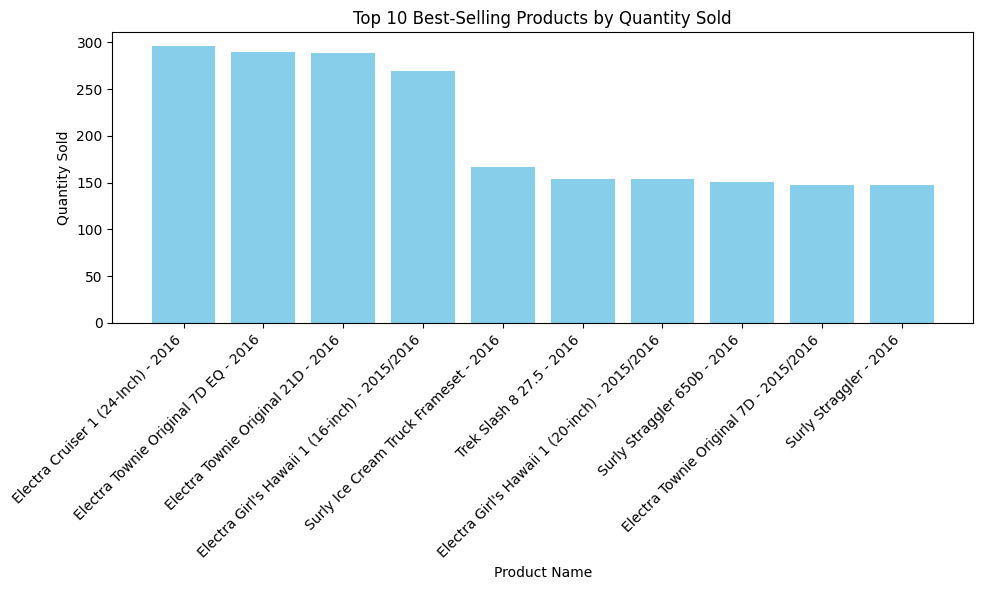

,product_name,total_quantity
0,Electra Cruiser 1 (24-Inch) - 2016,296
1,Electra Townie Original 7D EQ - 2016,290
2,Electra Townie Original 21D - 2016,289
3,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,269
4,Surly Ice Cream Truck Frameset - 2016,167
5,Trek Slash 8 27.5 - 2016,154
6,Electra Girl's Hawaii 1 (20-inch) - 2015/2016,154
7,Surly Straggler 650b - 2016,151
8,Electra Townie Original 7D - 2015/2016,148
9,Surly Straggler - 2016,147


In [2]:
await PromptToQueryResult(prompt_rephrase=True, debug=False ,selectedService=Service.AzureOpenAI)
